In [37]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import cv2
from glob import glob
import seaborn as sns
sns.set()
import keras
import sklearn
import skimage
from skimage.transform import resize
import time
import random
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical


In [39]:
train = "D:/FAMU-REU/projects/Myra/train"

test = "D:/FAMU-REU/projects/Myra/test"

val = "D:/FAMU-REU/projects/Myra/valid"

root_folder = "D:/FAMU-REU/projects/Myra/numpy_arrays"

LOAD_FROM_IMAGES = False

def get_data(folder):
    x = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith("."):
            if folderName in ["non_autistic"]:
                label = 0
            elif folderName in ["autistic"]:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder +"/" +folderName+"/")):
                img_file = cv2.imread(folder + "/" +folderName + "/" + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file,(128,128,3), mode = "constant",anti_aliasing=True)
                    #img_file = rgb2gray(img_file)
                    img_arr = np.asarray(img_file)
                    x.append(img_arr)
                    y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)
    return x,y

if LOAD_FROM_IMAGES:
    X_train,y_train = get_data(train)
    X_test, y_test = get_data(test)
    X_val,y_val = get_data(val)
    
    np.save("xtrain.npy",X_train)
    np.save("ytrain.npy",y_train)
    np.save("xtest.npy",X_test)
    np.save("ytest.npy",y_test)
    np.save("xval.npy",X_val)
    np.save("yval.npy",y_val)
else:
    X_train = np.load(root_folder+"/xtrain.npy")
    y_train = np.load(root_folder+"/ytrain.npy")
    X_test = np.load(root_folder+"/xtest.npy")
    y_test = np.load(root_folder+"/ytest.npy")
    X_val = np.load(root_folder+"/xval.npy")
    y_val = np.load(root_folder+"/yval.npy")

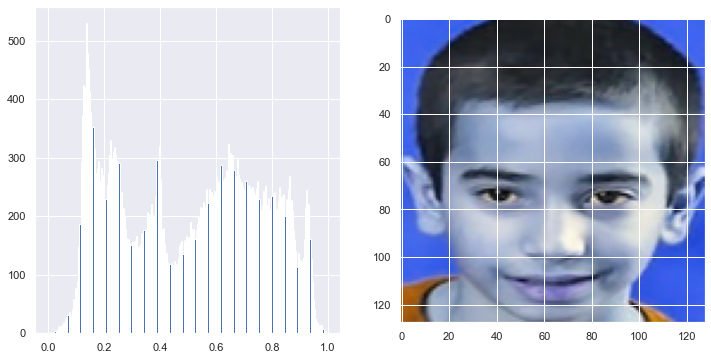

In [40]:
def plot_histogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(a.ravel(),bins=255)
    plt.subplot(1,2,2)
    plt.imshow(a,vmin=0,vmax=1)
    plt.show()
    
plot_histogram(X_train[3])

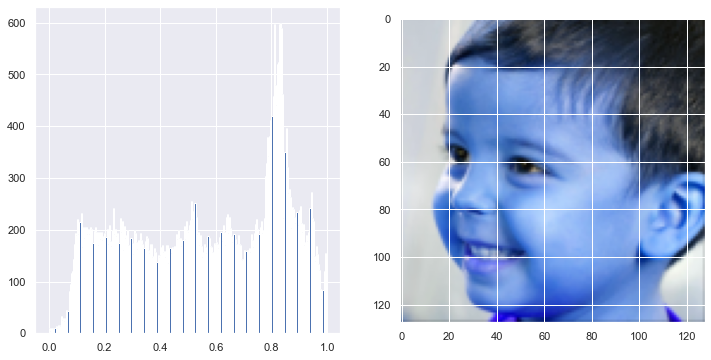

In [41]:
plot_histogram(X_test[3])

C:\Users\carlo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='labels', ylabel='count'>

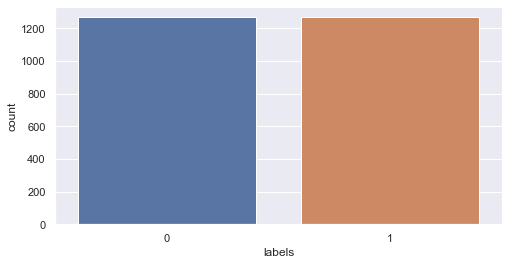

In [42]:
# Defining labels
plt.figure(figsize=(8,4))

map_characters = {0:"non_autistic",1:"autistic"}
dict_characters = map_characters

df = pd.DataFrame()
df["labels"]=y_train
lab = df["labels"]
dist=lab.value_counts()
sns.countplot(lab)

In [51]:
# Importing the required layers operation and activation function to build your model
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [61]:
# Defining basic parameters
batch_size = 32
epochs = 15
num_classes = 2
n_samples, row, column, channel = X_train.shape

In [62]:
# Creating the model
#model = models.Sequential()
#model.add(layers.Conv2D(64,(3,3),activation="relu",input_shape=(128,128,3)))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(layers.Conv2D(64,(3,3),activation="relu"))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(64,(3,3),activation="relu"))
#model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Flatten())
#model.add(layers.Dense(128,activation="relu"))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(layers.Dense(2,activation="softmax"))
# Buidling your CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(row, column, channel),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax')) 

model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)      

In [73]:
#model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [64]:
batch_size=32
epochs=15

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=50,
    restore_best_weights=True
)

In [74]:
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test) 
val_Y_one_hot = to_categorical(y_val)
print(train_Y_one_hot.shape)
print(val_Y_one_hot.shape)
print(val_Y_one_hot.shape)
print(X_train.shape)

history = model.fit(X_train, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=((X_val,val_Y_one_hot)))

(2538, 2)
(200, 2)
(200, 2)
(2538, 128, 128, 3)
Epoch 1/2
80/80 [==============================] - 82s 989ms/step - loss: 0.6809 - accuracy: 0.5890 - val_loss: 0.6119 - val_accuracy: 0.6750
Epoch 2/2
80/80 [==============================] - 78s 971ms/step - loss: 0.5699 - accuracy: 0.7004 - val_loss: 0.5759 - val_accuracy: 0.6800


In [75]:
# evaluating the model
test_eval = model.evaluate(X_test, test_Y_one_hot, batch_size=batch_size, verbose=1)
print("The loss of the model is {0:f}, and the accurracy is {1:f}".format(test_eval[0],test_eval[1]))

7/7 [==============================] - 2s 294ms/step - loss: 0.4103 - accuracy: 0.7950
The loss of the model is 0.410301, and the accurracy is 0.795000


In [80]:
# using fashion_trained_history information to provide the performance of the model during the training stage
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

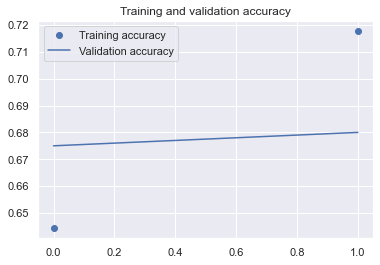

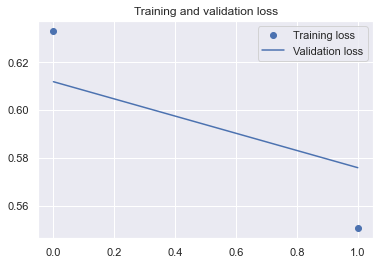

In [81]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [82]:
predicted = model.predict(X_test)

# taking the max argument
predicted = np.argmax(np.round(predicted),axis=1)
print(predicted.shape)
print(y_test.shape)

(200,)
(200,)


Found 159 correct labels


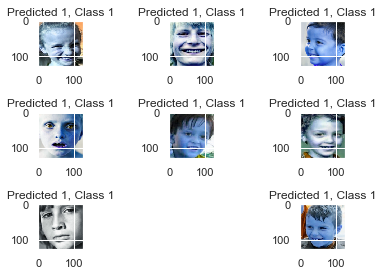

In [85]:
# Now let's select those samples that were correctly classified.
correct = np.where(predicted==y_test)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(128,128,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted[correct], y_test[correct]))
    plt.tight_layout()

Found 41 incorrect labels


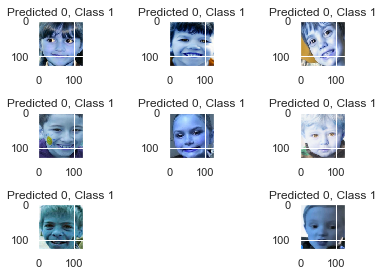

In [86]:
# Now let's select those samples that were incorrectly classified.
incorrect = np.where(predicted!=y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(128,128,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [87]:
#Printing Classification reports
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.82      0.75      0.79       100
     Class 1       0.77      0.84      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



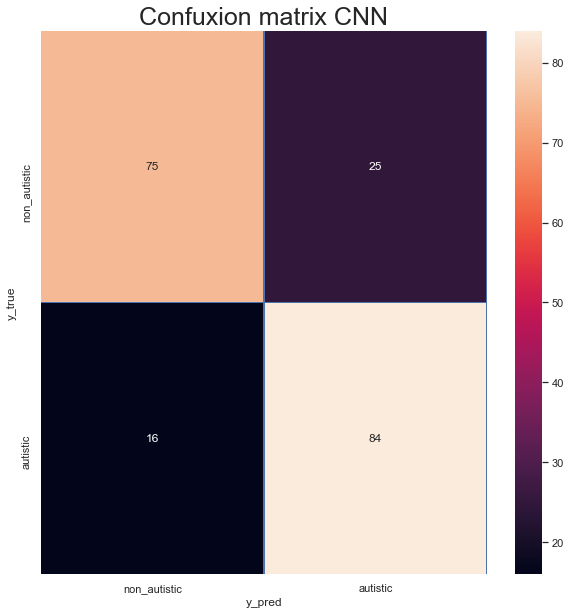

(200,)


In [111]:
# Prining confusion matrix

labels=['non_autistic','autistic']
y_classes = np.array([np.argmax(y, axis=None, out=None) for y in y_test])
cm=confusion_matrix(y_classes,predicted)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="b",fmt=".0f",ax=ax)
plt.title("Confuxion matrix CNN", size = 25)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()
print(y_classes.shape)